In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
Data = pd.read_csv('Faellesdata.csv')
DataFinal = Data.drop([
        'rsph', 'x', 'y', 'vx', 'vy', 'rsph_form', 'x_form', 
        'y_form', 'z_form', 'vx_form', 'vy_form',
        'vz_form', 'Rcyl_form', 'phi_form', 'vRcyl_form', 'vphi_form'
       ], axis = 1)

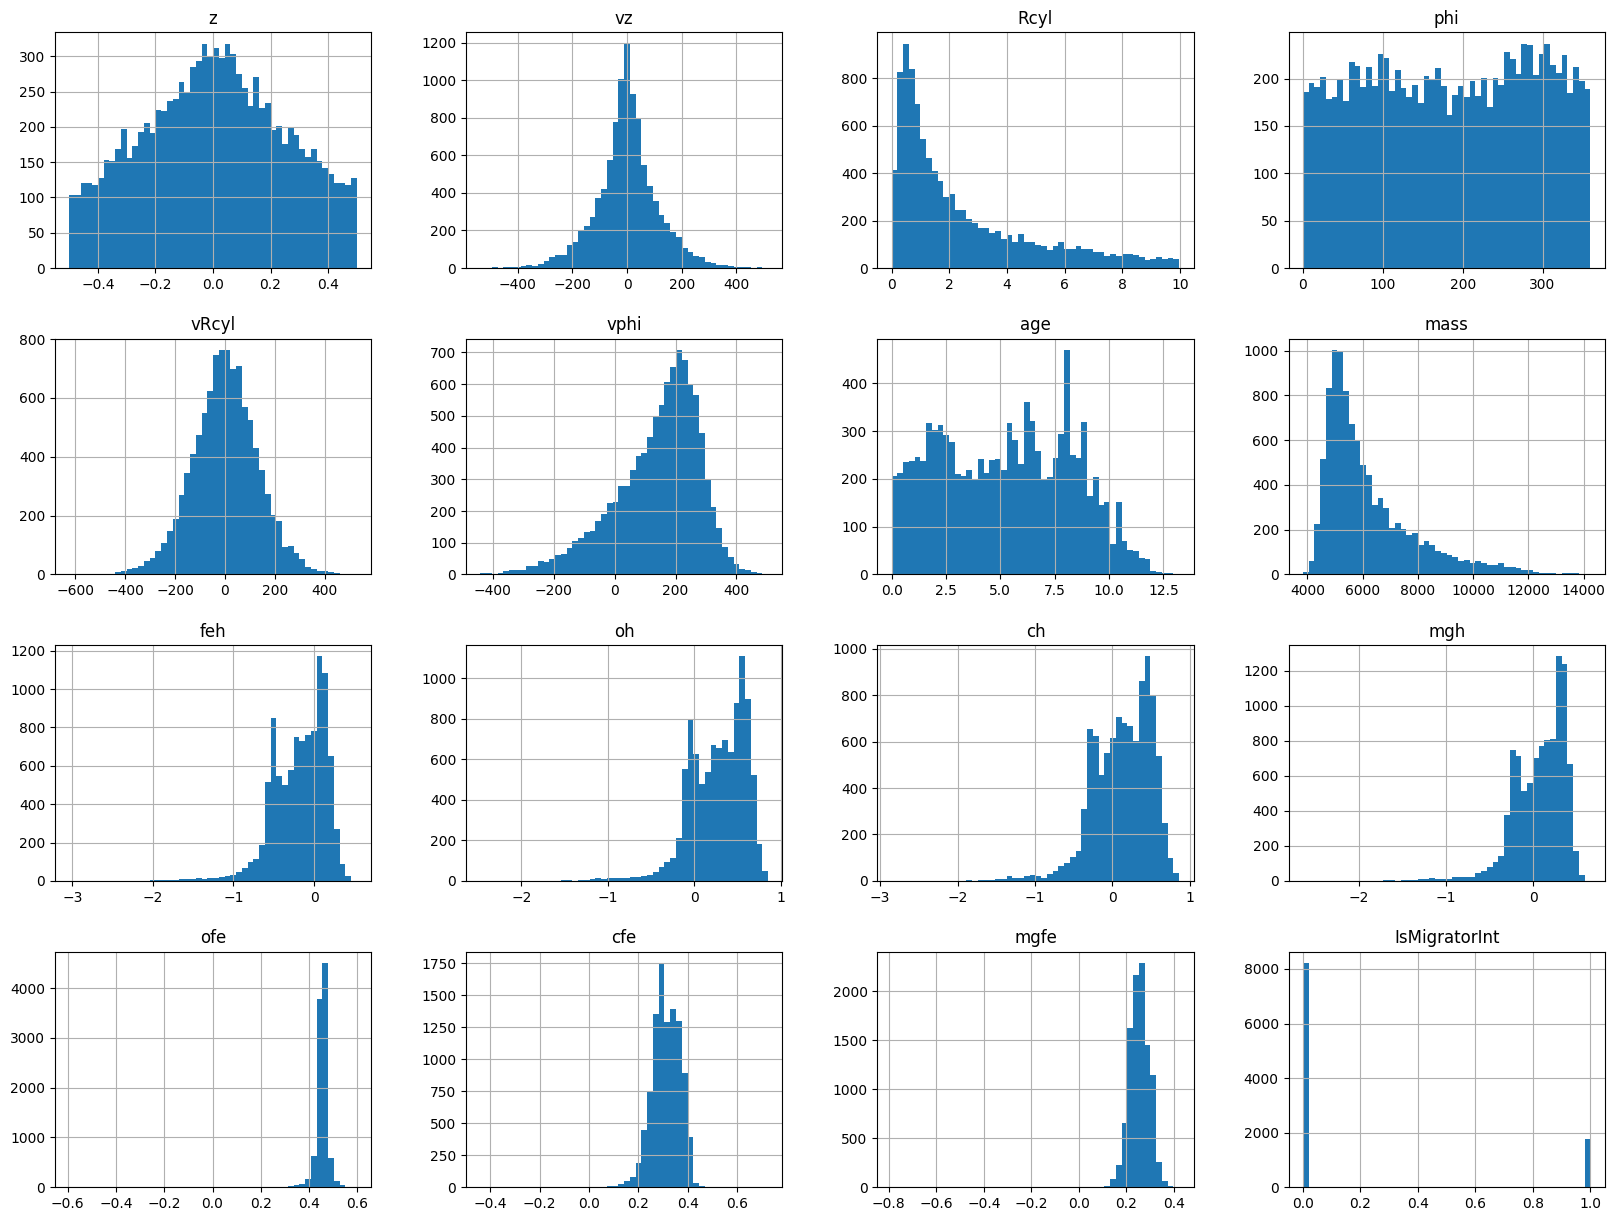

In [27]:
DataFinal.hist(bins = 50, figsize = (20, 15));
plt.savefig("Histograms")

In [30]:
import statsmodels.api as sm
import time
import itertools
from ISLP.models import (ModelSpec as MS,
                         summarize, poly)

In [42]:
DataFinal.iloc[:,:-2]

,z,vz,Rcyl,phi,vRcyl,vphi,age,mass,feh,oh,ch,mgh,ofe,cfe,mgfe
0,0.361,-92.909,1.236,341.267,-82.221,166.156,6.961,6600.002,-0.253,0.194,0.053,0.026,0.448,0.306,0.279
1,-0.162,24.089,1.525,300.646,42.443,257.005,1.891,5529.467,0.141,0.610,0.520,0.366,0.470,0.379,0.225
2,-0.369,-21.360,6.925,162.806,-85.396,283.916,0.963,8819.483,0.046,0.517,0.400,0.283,0.471,0.355,0.238
3,-0.330,-26.248,5.832,0.303,175.200,128.138,1.231,6918.149,0.129,0.596,0.503,0.351,0.466,0.374,0.222
4,-0.243,304.173,0.292,13.944,286.408,-28.238,8.985,6125.553,-0.536,-0.069,-0.262,-0.230,0.467,0.274,0.306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.123,22.456,0.705,307.465,12.126,179.076,5.120,10796.726,0.048,0.485,0.393,0.278,0.437,0.344,0.230
9996,0.024,-202.398,0.552,190.765,-15.763,-78.668,8.986,5159.025,-0.524,-0.061,-0.224,-0.221,0.463,0.300,0.304
9997,-0.151,-87.273,2.180,95.685,-217.565,75.266,8.757,4770.375,-0.543,-0.058,-0.271,-0.220,0.485,0.272,0.323
9998,-0.056,-104.503,0.356,211.362,-170.438,-44.733,5.870,5257.479,-0.085,0.356,0.227,0.170,0.442,0.312,0.255


In [43]:
# Found on google
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    X = MS(list(feature_set)).fit_transform(DataFinal[list(feature_set)])
    model = sm.GLM(
        DataFinal["IsMigratorInt"]
        , X
        , family = sm.families.Binomial()
        )
    regr = model.fit()
    TErate = np.mean((regr.predict(X) >= 0.5) != DataFinal['IsMigratorInt'])
    return {"model": regr, "TErate": TErate}

def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(DataFinal.iloc[:,:-2], k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['TErate'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [47]:
models_best = pd.DataFrame(columns=["TErate", "model"])

tic = time.time()
for i in range(4):
    models_best.loc[i] = getBest(i)
 
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 1 models on 0 predictors in 0.0328824520111084 seconds.
Processed 15 models on 1 predictors in 0.4691050052642822 seconds.
Processed 105 models on 2 predictors in 5.767356872558594 seconds.
Processed 455 models on 3 predictors in 26.514844179153442 seconds.
Total elapsed time: 32.96304106712341 seconds.


In [50]:
models_best.apply(lambda row: row[1].params, axis=1) # get the parameters of the best model for each number of predictors


C:\Users\chril\AppData\Local\Temp\ipykernel_182036\3016688939.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  models_best.apply(lambda row: row[1].params, axis=1) # get the parameters of the best model for each number of predictors


,Rcyl,ch,intercept,vphi
0,NaN,NaN,-1.533378,NaN
1,0.475677,NaN,-3.076232,NaN
2,0.453408,NaN,-3.406676,0.002375
3,0.475344,-1.271478,-3.620855,0.004132
